<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: [Yury Kashnitskiy](https://yorko.github.io). Translated by [Sergey Oreshkov](https://www.linkedin.com/in/sergeoreshkov/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center> Assignment #8 (demo)

## <center> Implementation of online regressor

Here we'll implement a regressor trained with stochastic gradient descent (SGD). Fill in the missing code. If you do evething right, you'll pass a simple embedded test.

## <center>Linear regression and Stochastic Gradient Descent

In [98]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Implement class `SGDRegressor`. Specification:
- class is inherited from `sklearn.base.BaseEstimator`
- constructor takes parameters `eta` – gradient step ($10^{-3}$ by default) and `n_epochs` – dataset pass count (3 by default)
- constructor also creates `mse_` and `weights_` lists in order to track mean squared error and weight vector during gradient descent iterations
- Class has `fit` and `predict` methods
- The `fit` method takes matrix `X` and vector `y` (`numpy.array` objects) as parameters, appends column of ones to  `X` on the left side, initializes weight vector `w` with **zeros** and then makes `n_epochs` iterations of weight updates (you may refer to this [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-8-vowpal-wabbit-fast-learning-with-gigabytes-of-data-60f750086237) for details), and for every iteration logs mean squared error and weight vector `w` in corresponding lists we created in the constructor. 
- Additionally the `fit` method will create `w_` variable to store weights which produce minimal mean squared error
- The `fit` method returns current instance of the `SGDRegressor` class, i.e. `self`
- The `predict` method takes `X` matrix, adds column of ones to the left side and returns prediction vector, using weight vector `w_`, created by the `fit` method.

In [99]:
class SGDRegressor(BaseEstimator):
    # you code here
    def __init__(self, eta=1e-3, n_epochs=3):
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        one = np.ones(shape = (X.shape[0], 1))
        X = np.hstack([one, X])
        w = np.zeros(shape = (X.shape[1]))
        for i in tqdm(range(self.n_epochs)):
            for j in range(X.shape[0]):
                y_p = w.dot(X[j, :])
                n_w = w.copy()
                #n_w[0]-=self.eta*(y[j] - y_p)
                for t in range(0, X.shape[1]):
                    n_w[t]+=self.eta*(y[j] - y_p)*X[j,t]
                w = n_w.copy()
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self
                  
    def predict(self, X):
        one = np.ones(shape = (X.shape[0], 1))
        X = np.hstack([one, X])
        return X.dot(self.w_)  
        

Let's test out the algorithm on height/weight data. We will predict heights (in inches) based on weights (in lbs).

In [100]:
data_demo = pd.read_csv('../input/weights_heights.csv')

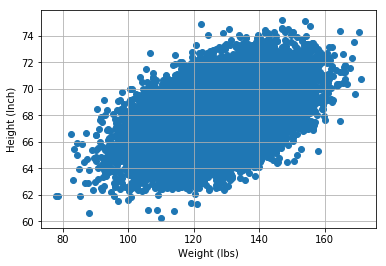

In [101]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (Inch)')
plt.grid();

In [102]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Perform train/test split and scale data.

In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

Train created `SGDRegressor` with `(X_train_scaled, y_train)` data. Leave default parameter values for now.

In [105]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:16<00:00,  5.37s/it]


SGDRegressor(eta=0.001, n_epochs=3)

Draw a chart with training process  – dependency of mean squared error from the i-th SGD iteration number.

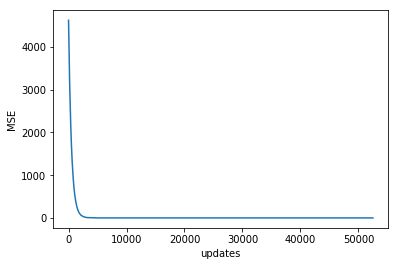

In [106]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_)
plt.xlabel('updates')
plt.ylabel('MSE');

Print the minimal value of mean squared error and the best weights vector.

In [107]:
print('MIN MSE:{0}, best weights:{1}'.format(min(sgd_reg.mse_), sgd_reg.weights_[np.argmin(sgd_reg.mse_)]))

MIN MSE:2.7151352406643627, best weights:[67.9898497   0.94447605]


Draw chart of model weights ($w_0$ and $w_1$) behavior during training.

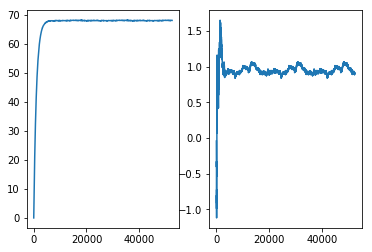

In [119]:
fig, axs = plt.subplots(1,2)
axs[0].plot(range(len(sgd_reg.weights_)), 
         [w[0] for w in sgd_reg.weights_]);
axs[1].plot(range(len(sgd_reg.weights_)), 
         [w[1] for w in sgd_reg.weights_]);

Make a prediction for hold-out  set `(X_valid_scaled, y_valid)` and check MSE value.

In [120]:
# you code here
sgd_holdout_mse=mean_squared_error(y_valid, 
                                        sgd_reg.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

Do the same thing for `LinearRegression` class from `sklearn.linear_model`. Evaluate MSE for hold-out set.

In [121]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid, 
                                        lm.predict(X_valid_scaled))
linreg_holdout_mse

[0.94537278] 67.98930834742858


2.670830767667634

In [122]:
try:
    assert (sgd_holdout_mse - linreg_holdout_mse) < 1e-4
    print('Correct!')
except AssertionError:
    print("Something's not good.\n Linreg's holdout MSE: {}"
          "\n SGD's holdout MSE: {}".format(linreg_holdout_mse, 
                                            sgd_holdout_mse))

Correct!
